In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math

import acquire
from acquire import add_county_column
import prepare
import features

from statsmodels.formula.api import ols

from sklearn.model_selection import train_test_split

from sklearn.metrics import mean_squared_error, explained_variance_score, r2_score

from sklearn.feature_selection import SelectKBest, f_regression, RFE

from sklearn.linear_model import LinearRegression, LassoLars

from sklearn.preprocessing import PolynomialFeatures

import warnings
warnings.filterwarnings('ignore')

In [2]:
df = acquire.acquire_cache_data()

In [3]:
df.head()

,calculatedfinishedsquarefeet,bathroomcnt,bedroomcnt,taxvaluedollarcnt
0,1458.0,2.0,3.0,136104.0
1,1421.0,1.0,2.0,35606.0
2,2541.0,3.0,4.0,880456.0
3,1650.0,2.0,3.0,614000.0
4,693.0,1.0,2.0,274237.0


In [4]:
from os import path
from acquire import get_connection
def acquire_cache_tax_data():
    if not path.isfile('zillow_tax_rate.csv'):
        query = '''
        SELECT p.fips, ROUND((p.taxamount / p.taxvaluedollarcnt) * 100, 2) AS taxrate
        FROM properties_2017 AS p
        JOIN predictions_2017 AS pr USING (parcelid) 
        WHERE p.propertylandusetypeid IN (261, 262, 263, 264, 266, 268, 273, 275, 276, 279)
        AND pr.transactiondate between '2017-05-01' AND '2017-06-30'
        '''
        url = get_connection('zillow')
        zillow = pd.read_sql(query, url)
        zillow.to_csv('zillow_tax_rate.csv')
    zillow = pd.read_csv('zillow_tax_rate.csv')
    zillow.drop(columns=['Unnamed: 0'], inplace=True)
    zillow['County'] = zillow.apply(lambda row: add_county_column(row), axis = 1)
    zillow.drop(columns=['fips'], inplace=True)
    return zillow

In [5]:
df = acquire_cache_tax_data()
df.head()

,taxrate,County
0,1.70,Los Angeles
1,1.53,Los Angeles
2,1.12,Orange
3,1.25,Los Angeles
4,1.19,Los Angeles


In [6]:
los_angeles_taxrate = df[df.County == 'Los Angeles'].taxrate
orange_taxrate = df[df.County == 'Orange'].taxrate
ventura_taxrate = df[df.County == 'Ventura'].taxrate

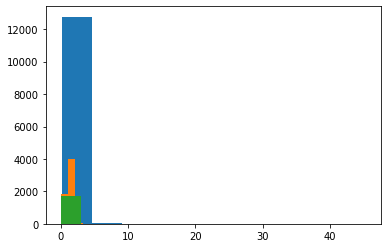

In [7]:
plt.hist(los_angeles_taxrate)
plt.hist(orange_taxrate)
plt.hist(ventura_taxrate)
plt.show()

In [8]:
los_angeles_taxrate.describe()

count    12807.000000
mean         1.380155
std          0.672991
min          0.110000
25%          1.210000
50%          1.250000
75%          1.390000
max         45.290000
Name: taxrate, dtype: float64

In [9]:
orange_taxrate.describe()

count    5845.000000
mean        1.205100
std         0.292402
min         0.010000
25%         1.050000
50%         1.150000
75%         1.260000
max        10.740000
Name: taxrate, dtype: float64

In [10]:
ventura_taxrate.describe()

count    1711.000000
mean        1.212215
std         0.743119
min         0.080000
25%         1.070000
50%         1.120000
75%         1.190000
max        29.490000
Name: taxrate, dtype: float64

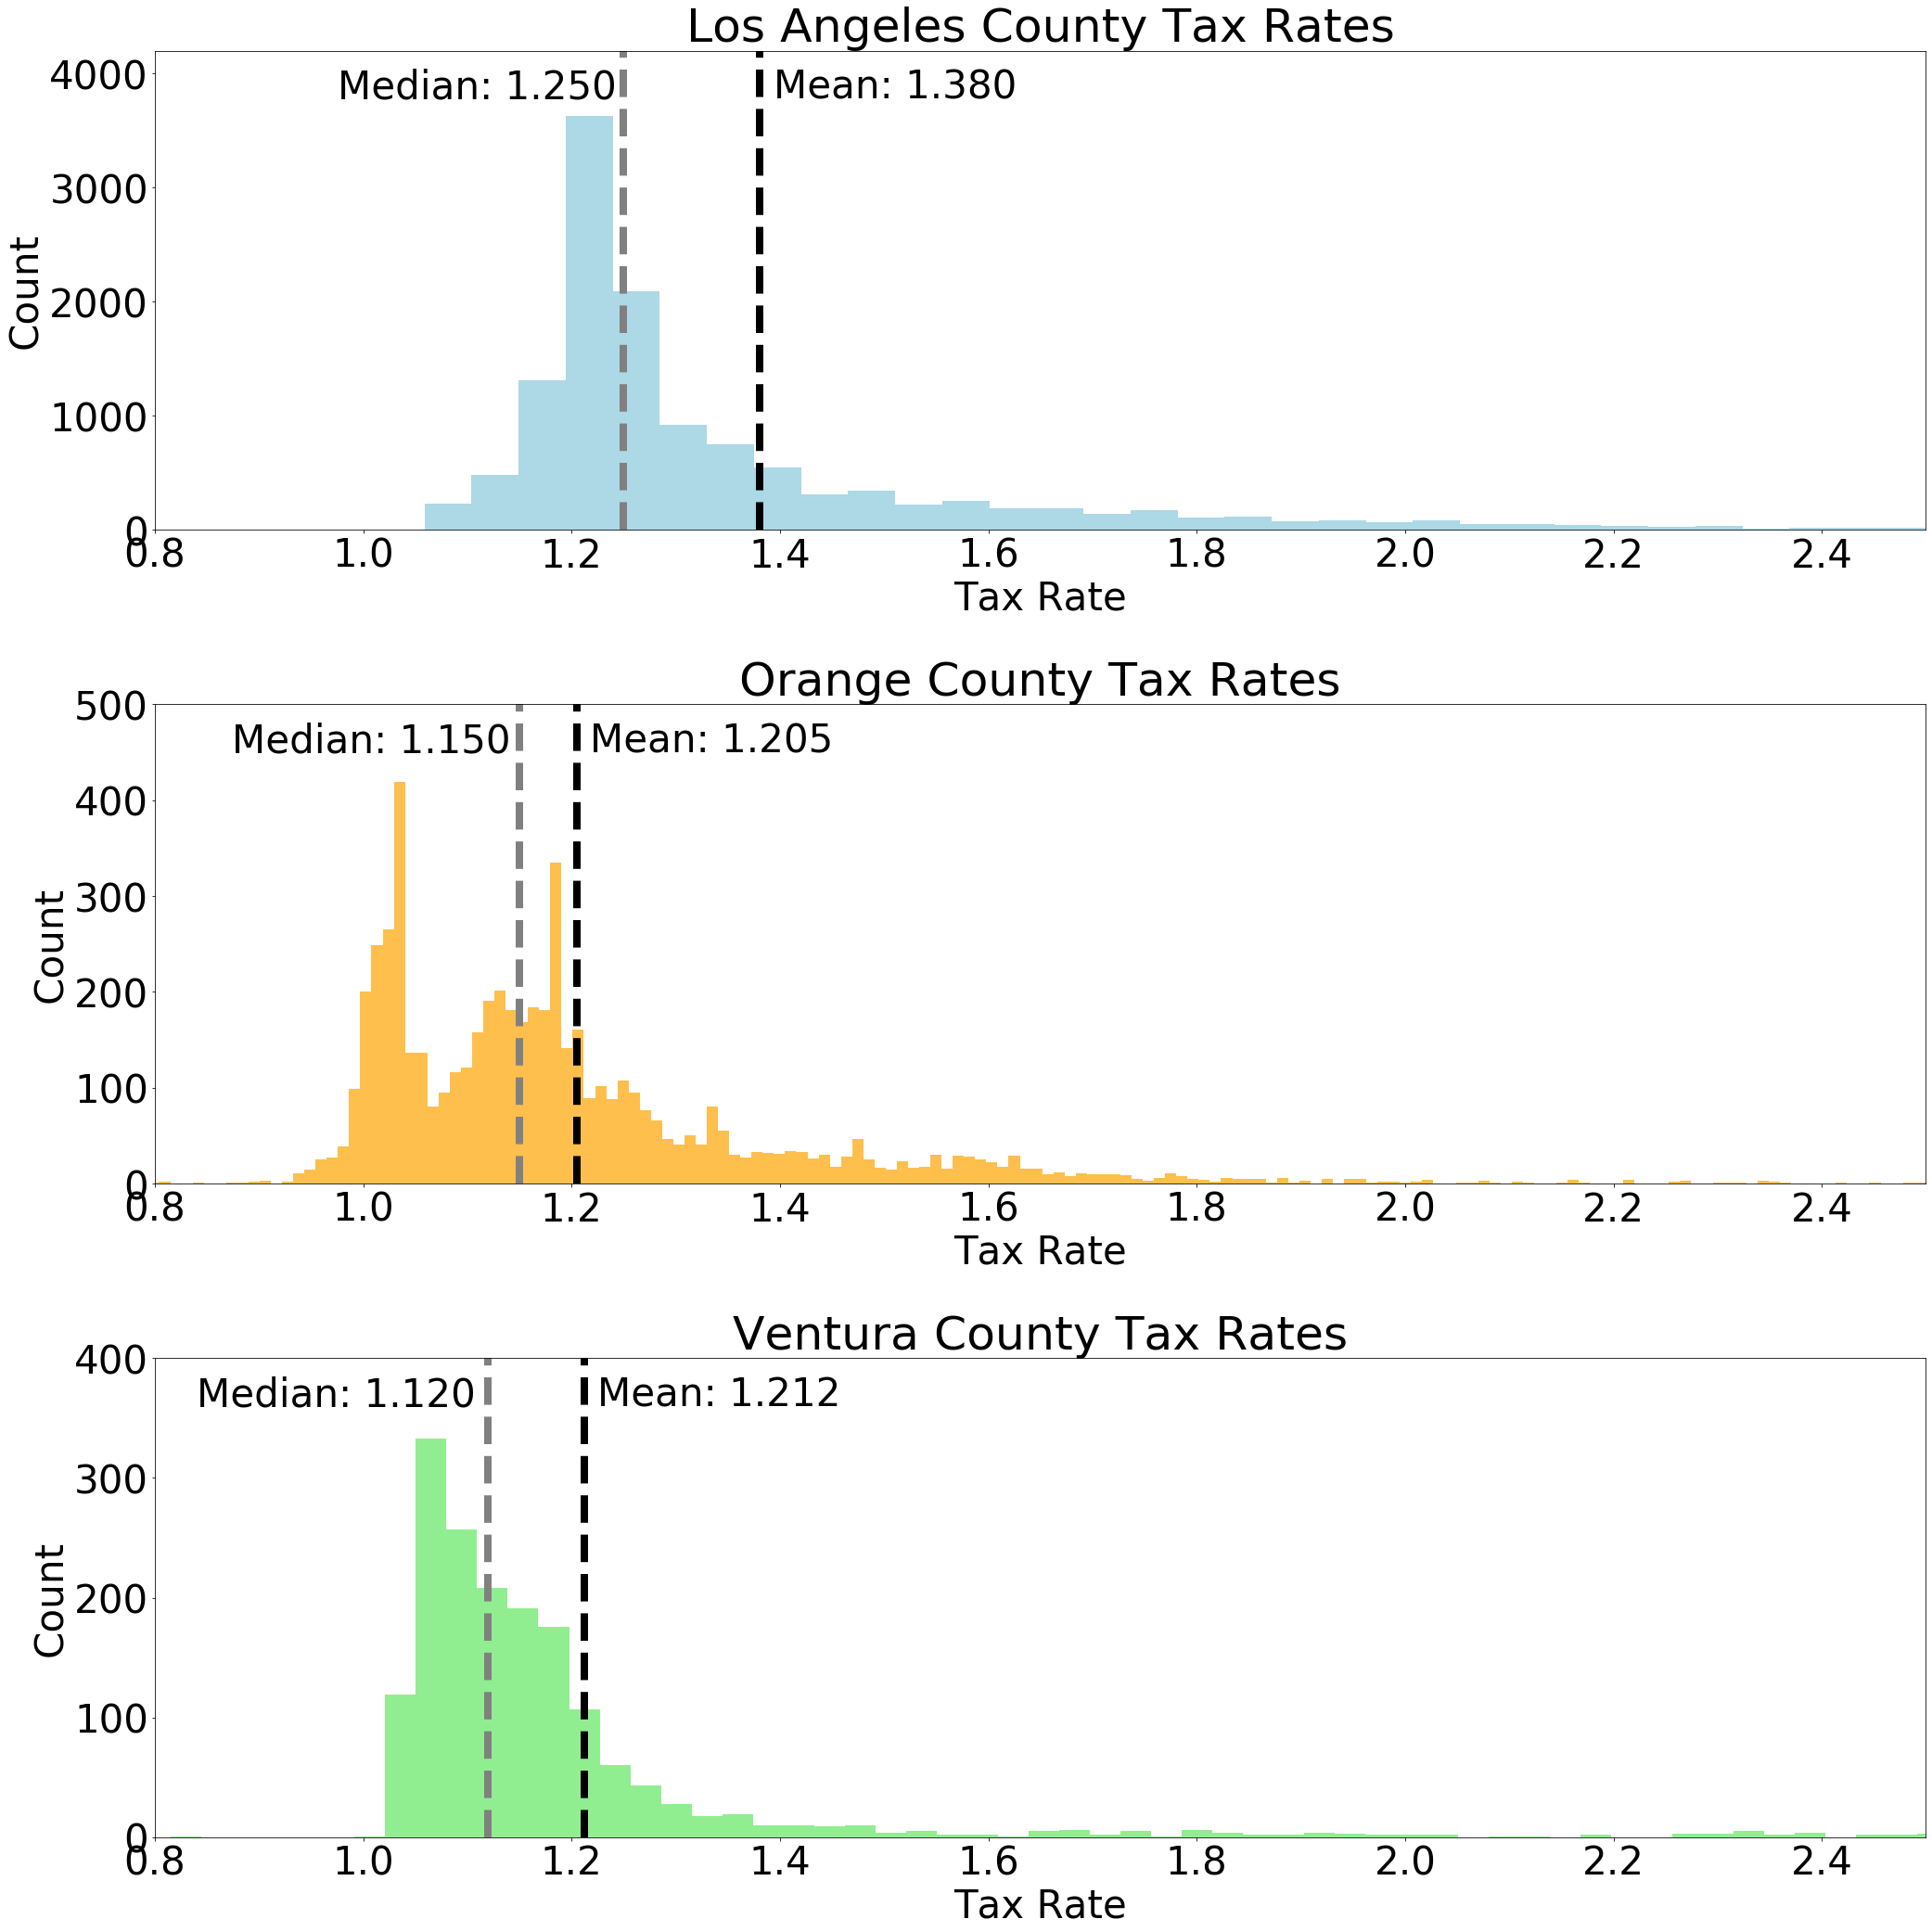

In [11]:
plt.rcParams.update({'font.size': 42})

plt.figure(figsize=(30,30))
plt.subplot(3,1,1)
plt.hist(los_angeles_taxrate, bins = 1000, color = 'lightblue')
plt.xlim(.8, 2.5)
plt.ylim(0, 4200)
plt.title('Los Angeles County Tax Rates')
plt.ylabel('Count')
plt.xlabel('Tax Rate')
min_ylim, max_ylim = plt.ylim()
plt.axvline(los_angeles_taxrate.mean(), color='k', linestyle='dashed', linewidth=8)
plt.text(los_angeles_taxrate.mean()*1.01, max_ylim*0.9, 'Mean: {:.3f}'.format(los_angeles_taxrate.mean()))
plt.axvline(los_angeles_taxrate.median(), color='gray', linestyle='dashed', linewidth=8)
plt.text(los_angeles_taxrate.median()*.78, max_ylim*0.9, 'Median: {:.3f}'.format(los_angeles_taxrate.median()))

plt.subplot(3,1,2)
plt.hist(orange_taxrate, bins = 1000, color = 'orange', alpha = 0.7)
plt.xlim(.8, 2.5)
plt.ylim(0, 500)
plt.title('Orange County Tax Rates')
plt.ylabel('Count')
plt.xlabel('Tax Rate')
min_ylim, max_ylim = plt.ylim()
plt.axvline(orange_taxrate.mean(), color='k', linestyle='dashed', linewidth=8)
plt.text(orange_taxrate.mean()*1.01, max_ylim*0.9, 'Mean: {:.3f}'.format(orange_taxrate.mean()))
plt.axvline(orange_taxrate.median(), color='gray', linestyle='dashed', linewidth=8)
plt.text(orange_taxrate.median()*.76, max_ylim*0.9, 'Median: {:.3f}'.format(orange_taxrate.median()))

plt.subplot(3,1,3)
plt.hist(ventura_taxrate, bins = 1000, color = 'lightgreen')
plt.xlim(.8, 2.5)
plt.ylim(0, 400)
plt.title('Ventura County Tax Rates')
plt.ylabel('Count')
plt.xlabel('Tax Rate')
min_ylim, max_ylim = plt.ylim()
plt.axvline(ventura_taxrate.mean(), color='k', linestyle='dashed', linewidth=8)
plt.text(ventura_taxrate.mean()*1.01, max_ylim*0.9, 'Mean: {:.3f}'.format(ventura_taxrate.mean()))
plt.axvline(ventura_taxrate.median(), color='gray', linestyle='dashed', linewidth=8)
plt.text(ventura_taxrate.median()*.75, max_ylim*0.9, 'Median: {:.3f}'.format(ventura_taxrate.median()))

plt.tight_layout()
plt.show()